<a href="https://colab.research.google.com/github/jiananwu72/Defect-Detection/blob/main/LFODemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install -q pyNSID sidpy SciFiReaders nanonispy gwyfile pyTEMlib wget ipympl importlib wget
!pip install numpy==1.26.4

ERROR: Operation cancelled by user


In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

import sys
sys.path.insert(0, '../../')
sys.path.insert(0, '../../../sidpy')
import sidpy

%load_ext autoreload
%autoreload 2

import pyTEMlib
import pyTEMlib.file_tools      # File input/ output library
import pyTEMlib.image_tools

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
Symmetry functions of spglib enabled
Qt dialogs are not available
SimpleITK not installed; Registration Functions for Image Stacks not available
install with: conda install -c simpleitk simpleitk 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


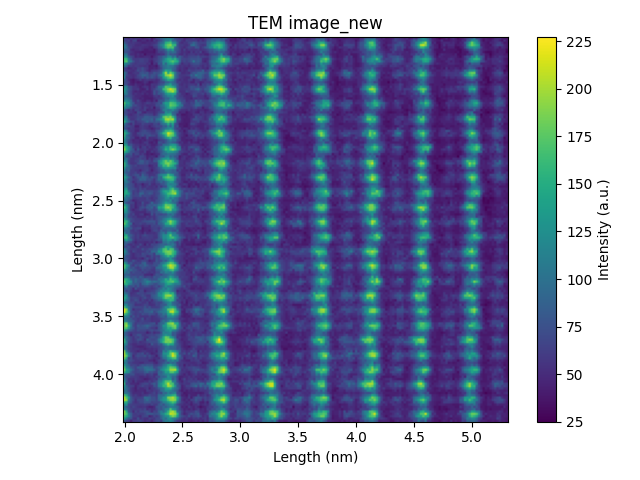

In [4]:
from PIL import Image
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# Change for each pictures
zooming_factor = 0.5
img_path = '/content/drive/MyDrive/Data/LFO/Picture2.png'
img = Image.open(img_path).convert('L')
image = np.array(img).astype(np.float32)
image = zoom(image, zooming_factor, order=3)

dataset = sidpy.Dataset.from_array(image)
dataset.quantity = 'Intensity'
dataset.title = 'TEM image'
dataset.units = 'a.u.'
dataset.data_type = sidpy.DataType.IMAGE
dataset.modality = 'Experimental'
dataset.set_dimension(0, sidpy.Dimension(np.arange(dataset.shape[0])*.02,
                                          name='x', units='nm', quantity='Length',
                                          dimension_type='spatial'))
dataset.set_dimension(1, sidpy.Dimension(np.arange(dataset.shape[1])*.02,
                                          name='y', units='nm', quantity='Length',
                                          dimension_type='spatial'))
left = 100
right = 10
top = 55
bottom = 55
dataset = dataset[left:-right, bottom:-top]
dataset.plot();

##Fourier Filtering

fft :
	smoothing : 1
	minimum_intensity : 6.417699173411594
	maximum_intensity : 12.054283093371888
source:  TEM image_new


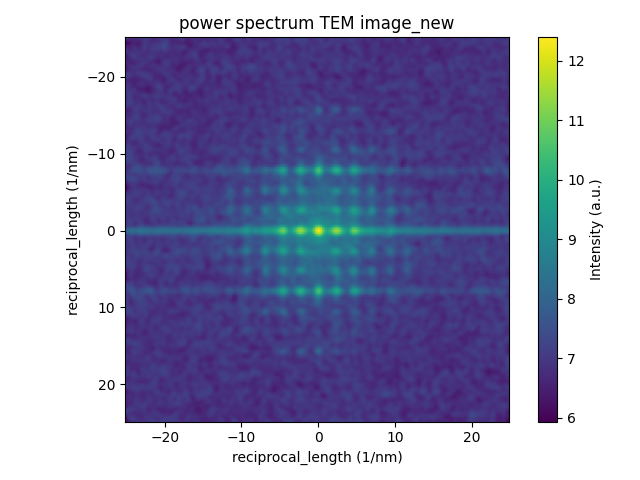

In [5]:
image = dataset
power_spectrum = pyTEMlib.image_tools.power_spectrum(image, smoothing=1)
power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
view = power_spectrum.plot()

Found 116 reflections


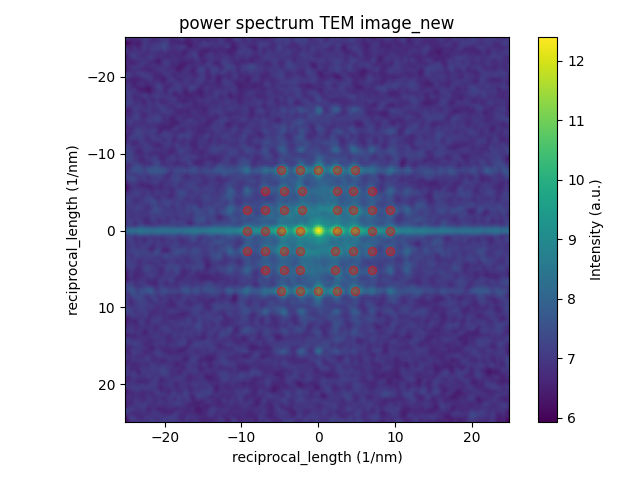

In [6]:
# ------Input----------
spot_threshold=0.05
# ---------------------

spots = []
spots, _ = pyTEMlib.image_tools.diffractogram_spots(power_spectrum, spot_threshold=spot_threshold)
spots = spots[np.linalg.norm(spots[:,:2],axis=1)<10,:]
spots = spots[np.linalg.norm(spots[:,:2],axis=1)>0.5,:]
power_spectrum.plot()

plt.gca().scatter(spots[:,0],spots[:,1], color='red', alpha=0.4);

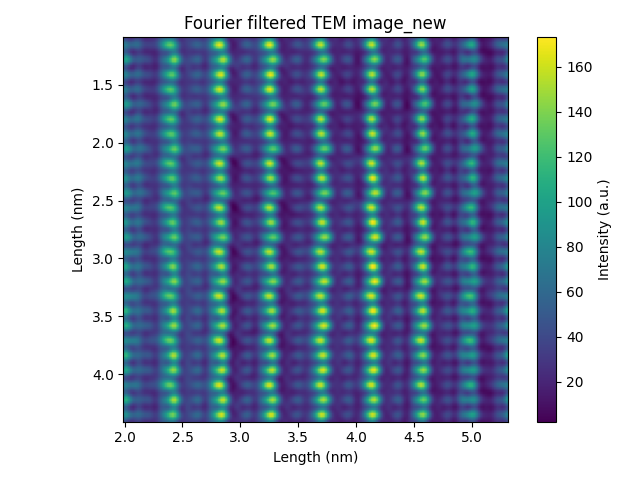

In [7]:
filtered_dataset = pyTEMlib.image_tools.adaptive_fourier_filter(image, spots,
                                                                low_pass=1.0, reflection_radius=0.5)
view = filtered_dataset.plot()

fft :
	smoothing : 1
	minimum_intensity : 6.417699173411594
	maximum_intensity : 12.054283093371888
source:  TEM image_new


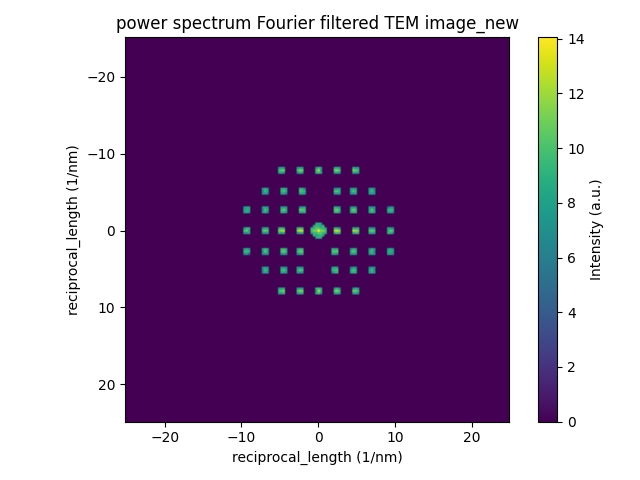

In [8]:
filtered_power_spectrum = pyTEMlib.image_tools.power_spectrum(filtered_dataset, smoothing=0)

power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
view = filtered_power_spectrum.plot()

##LR Convolution

2.5
smal
3 0.06
Deconvolution of  TEM image_new


  0%|          | 0/500 [00:00<?, ?it/s]

terminate
converged in 501 iterations

 Lucy-Richardson deconvolution converged in 501  iterations


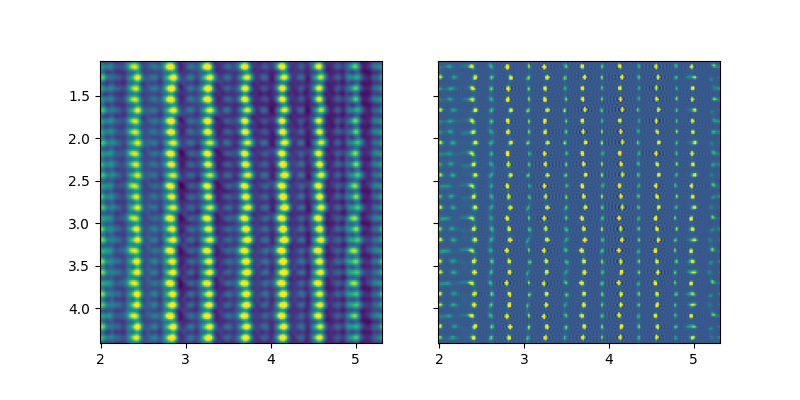

In [9]:
import pyTEMlib.probe_tools

# ------- Input ------
atoms_size = .05 # in nm
# --------------------
# image = dataset.sum(axis=0)
image = filtered_dataset

out_tags = {}
image.metadata['experiment']= {'convergence_angle': 30, 'acceleration_voltage': 200000.}

scale_x =image.x.slope
gauss_diameter = atoms_size/scale_x
print(gauss_diameter)
if gauss_diameter < 3:
    print('smal')
    gauss_diameter = 3
print(gauss_diameter, gauss_diameter*scale_x)
gauss_probe = pyTEMlib.probe_tools.make_gauss(image.shape[0], image.shape[1], gauss_diameter)

print('Deconvolution of ', dataset.title)
LR_dataset = pyTEMlib.image_tools.decon_lr(image, gauss_probe, verbose=False)

extent = LR_dataset.get_extent([0,1])
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image.T, extent = extent,vmax=np.median(np.array(image))+3*np.std(np.array(image)))
ax[1].imshow(LR_dataset.T, extent = extent, vmax=np.median(np.array(LR_dataset))+3*np.std(np.array(LR_dataset)));

In [31]:
LR_dataset.metadata.update({'analysis': {'Lucy_Richardson': {
                        'notebook': 'Image_Registration' ,
                        # 'notebook_version': __notebook_version__,
                        'input': dataset.title,
                        'probe_diameter': gauss_diameter,
                        'kind_of_probe': 'Gauss',
                        'probe_width': atoms_size
                        }}})

##Atom Finding


<ipython-input-52-90e3e5bc17d2>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)


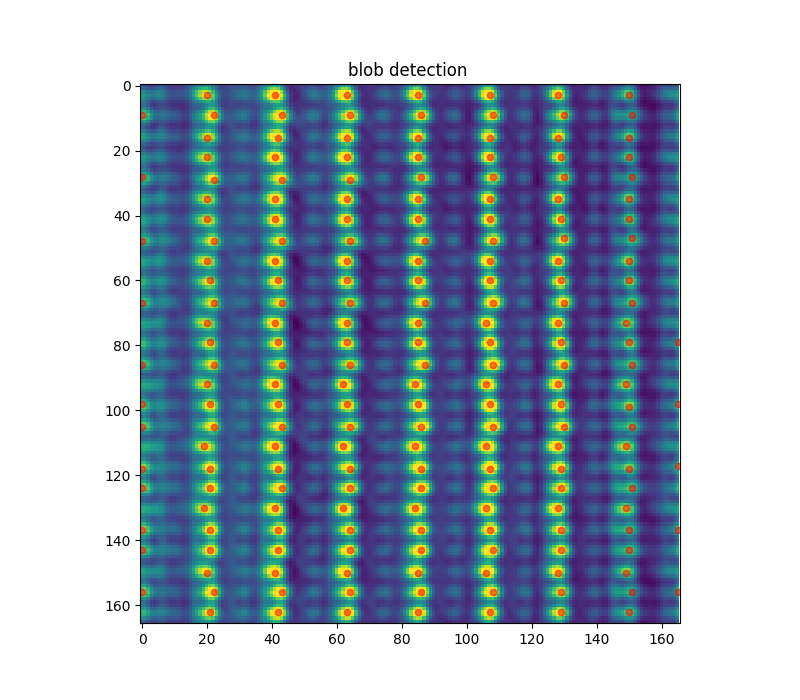

In [52]:
import skimage
# ------- Input ------
threshold = 20 #usally between 0.01 and 0.9  the smaller the more atoms
atom_size = .1 #in nm
min_atom_size = .04 #in nm
# ----------------------

image = filtered_dataset
image = image
#image = image_choice.dataset
# scale_x = pyTEMlib.file_tools.get_slope(image.dim_1)
blobs =  skimage.feature.blob_log(image, min_sigma = min_atom_size/scale_x, max_sigma=atom_size/scale_x, threshold=threshold)

fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")

plt.imshow(image.T, interpolation='nearest', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
plt.scatter(blobs[:, 0], blobs[:, 1], c='r', s=20, alpha = .5);

In [12]:
out_tags  =  {}
out_tags['analysis']= 'Atom Positions'
# out_tags['notebook']= __notebook__
# out_tags['notebook_version']= __notebook_version__

out_tags['atoms'] = blobs
out_tags['atom_size'] = atom_size #in nm gives the size of the atoms or resolution
out_tags['threshold'] =  threshold  #between 0.01 and 0.1
out_tags['pixel_size'] = scale_x


out_tags['name'] = 'Atom finding'
out_tags['title'] = out_tags['name']
tags = {'atom_pixel':  out_tags}
if isinstance(image.metadata['analysis'], str):
    image.metadata['analysis']={image.metadata['analysis']:{}}

image.metadata['analysis'].update(tags)

sidpy.Dataset of type IMAGE with:
 dask.array<sub, shape=(166, 166), dtype=float32, chunksize=(166, 166), chunktype=numpy.ndarray>
 data contains: Intensity (a.u.)
 and Dimensions: 
x:  Length (nm) of size (166,)
y:  Length (nm) of size (166,)
 with metadata: ['analysis', 'spots', 'low_pass', 'reflection_radius', 'experiment']
using radius  3 pixels


  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pyTEMlib/probe_tools.py:17: RuntimeWarning: invalid value encountered in divide
  probe = g / g.sum() * intensity


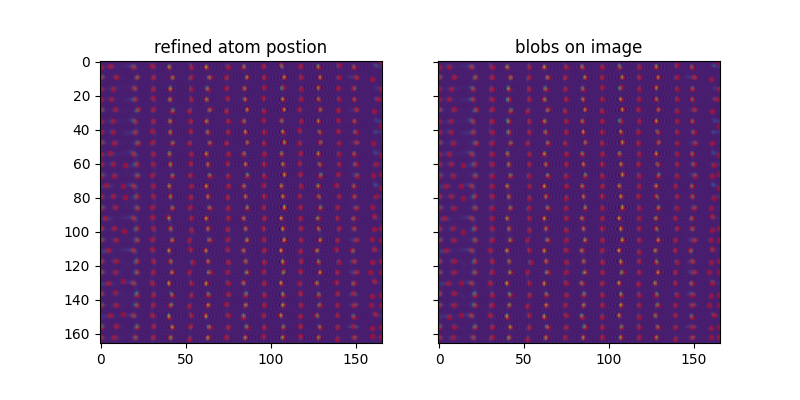

In [13]:
import pyTEMlib.atom_tools
atom_radius = 3
#atoms = atom_group['atoms'][()]
atoms = blobs
image = image-image.min()
print(image)

#atom_radius = 2
MaxInt = 0
MinInt = 0
maxDist = 2
sym = pyTEMlib.atom_tools.atom_refine(np.array(image), atoms, atom_radius, max_int = 0, min_int = 0, max_dist = 2)
refined_atoms = np.array(sym['atoms'])

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image.T)
ax[0].scatter(refined_atoms[:,0],refined_atoms[:,1],  s=10, alpha = 0.3, color = 'red')
ax[0].set_title('refined atom postion')
ax[1].imshow(image.T)
ax[1].scatter(atoms[:, 0], atoms[:, 1], c='r', s=10, alpha = .3);
ax[1].set_title('blobs on image');

##Position Analyzing

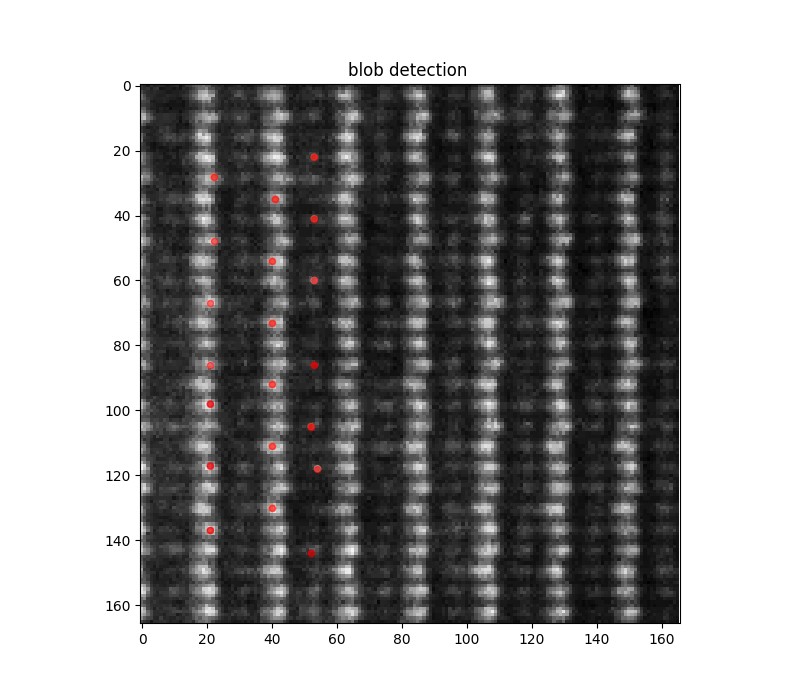

In [29]:
import scipy
import pyTEMlib.graph_tools
def breath_first(graph, initial, lattice_parameter, tolerance=1):

    neighbour_tree = scipy.spatial.KDTree(graph)
    distances, indices = neighbour_tree.query(graph,  # let's get all neighbours
                                              k=50)  # projection_tags['number_of_nearest_neighbours']*2 + 1)
    visited = []  # the atoms we visited
    angles = []  # atoms at ideal lattice
    sub_lattice = []
    sub_lattice = []  # atoms in base and disregarded
    queue = [initial]
    queue_angles=[0]

    while queue:
        node = queue.pop(0)
        angle = queue_angles.pop(0)

        if node not in visited and node not in sub_lattice:
            visited.append(node)
            angles.append(angle)
            neighbors = indices[node]
            for i, neighbour in enumerate(neighbors):
                if neighbour not in visited:
                    hopp = graph[node] - graph[neighbour]
                    distance_to_ideal = np.linalg.norm(hopp)
                    if distance_to_ideal < lattice_parameter - tolerance*5:
                        sub_lattice.append(neighbour)
                    elif np.min(np.abs(distance_to_ideal- lattice_parameter)) < tolerance:
                        queue.append(neighbour)
                        queue_angles.append(np.arctan2(hopp[1], hopp[0]))
    angles[0] = angles[1]
    out_atoms = np.stack([graph[visited][:, 0], graph[visited][:, 1], angles])
    return out_atoms.T, visited

def delete_rim_atoms(atoms, extent, rim_distance):
    rim = np.where(atoms[:, :2] - extent > -rim_distance)[0]
    middle_atoms = np.delete(atoms, rim, axis=0)
    rim = np.where(middle_atoms[:, :2].min(axis=1)<rim_distance)[0]
    middle_atoms = np.delete(middle_atoms, rim, axis=0)
    return middle_atoms
init = 10
dist = 19.5
hopped_atoms, indices = breath_first(blobs, init, dist, 1.5)
middle_atoms = pyTEMlib.graph_tools.delete_rim_atoms(hopped_atoms, image.shape, 20)

plt.close('all')
fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")

# plt.imshow(dataset.T, interpolation='nearest',cmap='gray', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
plt.imshow(dataset.T,cmap='gray')
plt.scatter(middle_atoms[:, 0], middle_atoms[:, 1], c=np.degrees(np.degrees(middle_atoms[:, 2])% 60), cmap = 'Reds', s=20, alpha = .5);
plt.scatter(middle_atoms[:, 0], middle_atoms[:, 1], c='red', s=20, alpha = .5);
#plt.scatter(blobs[init][0], blobs[init][1], c='orange')
angles = np.degrees(middle_atoms[:, 2])% 60

In [19]:
import ase
# crystal_name = 'SrTiO3'
# crystal = pyTEMlib.crystal_tools.structure_by_name(crystal_name)
# print(crystal_name)
# crystal
cdb = {'bto': {'crystal_name': 'bto',
               'symmetry': 'perovskite',
               'elements': ['Ba', 'Ti', 'O'],
               'a': 4.004}}
import ase.spacegroup
tags = cdb['bto'.lower()].copy()
atom_positions = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0)]
crystal = ase.spacegroup.crystal(tags['elements'], atom_positions, spacegroup=221, cellpar=tags['a'])
crystal

crystal.cell.lengths()[0]/image.x.slope/10
crystal.info = {'experimental': {'zone_axis': [0, 0, 1], 'angle': 0}}
layer = pyTEMlib.crystal_tools.get_projection(crystal)
print(layer.cell.angles())
gamma =  layer.cell.angles()[2]
layer.cell.lengths() , layer.cell.lengths()/image.x.slope/10 , layer.cell.angles(), np.linalg.norm(layer.positions[:,:2], axis=1), layer.get_scaled_positions()

projected atomic numbers
[90. 90. 90.]


(array([4.004, 4.004, 2.002]),
 array([20.02, 20.02, 10.01]),
 array([90., 90., 90.]),
 array([0.        , 2.83125555, 2.83125555, 2.002     , 2.002     ]),
 array([[0. , 0. , 0. ],
        [0.5, 0.5, 1. ],
        [0.5, 0.5, 0. ],
        [0. , 0.5, 1. ],
        [0.5, 0. , 1. ]]))

In [25]:
gamma

1.5707963267948966

425
 Average unit cell angle 0.7 with standard deviation 0.42; from 0.0 to 1.5


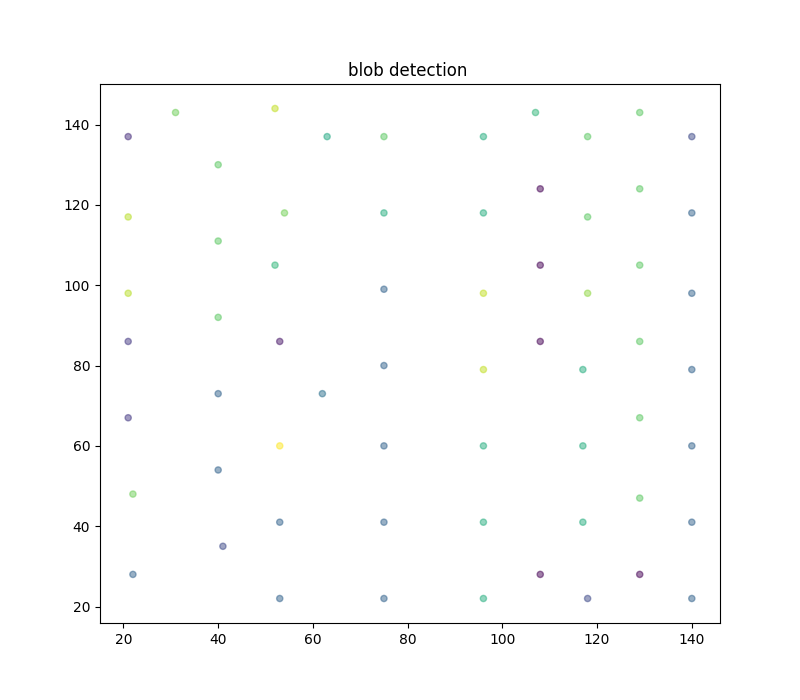

In [28]:
print(len(blobs))
fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")

# plt.imshow(image.T, interpolation='nearest',cmap='gray', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
plt.scatter(middle_atoms[:, 0], middle_atoms[:, 1], c=np.degrees(np.degrees(middle_atoms[:, 2])% gamma), cmap = 'viridis', s=20, alpha = .5);
angles = np.degrees(middle_atoms[:, 2])% gamma

print(f' Average unit cell angle {np.average(angles):.1f} with standard deviation {np.std(angles):.2f}; from {np.min(angles):.1f} to {np.max(angles):.1f}')

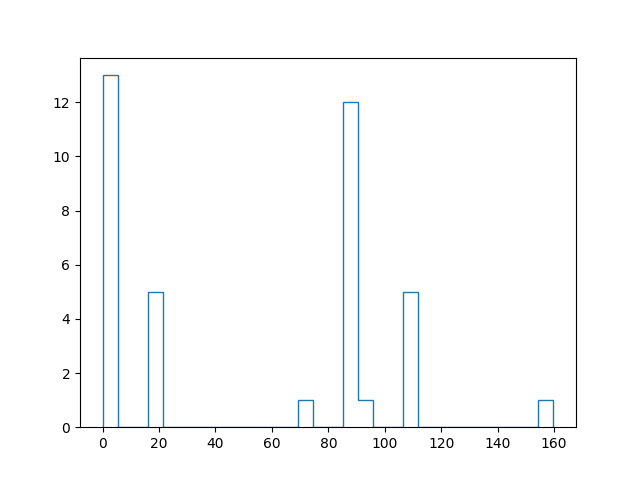

In [21]:
plt.figure()
plot_angles = np.append(angles, angles+gamma)
plot_angles[plot_angles<0] +=gamma
counts, bins = np.histogram(plot_angles, bins = 30)
plt.stairs(counts, bins)

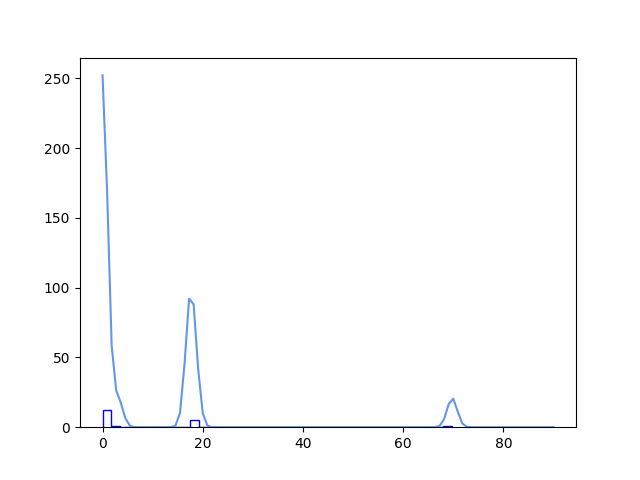

In [22]:
from sklearn.neighbors import KernelDensity
a = angles.reshape(-1,1)

kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)

kde.score_samples(a)

X_plot = np.linspace(0, 90, 100)[:, np.newaxis]

fig, ax = plt.subplots()


# Calculating the density using the gaussian kernel with bandwidth 0.5
kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(a)

# Calculating the log of the probability density function
log_dens = kde.score_samples(X_plot)

# Plotting the density curve
ax.plot(
    X_plot[:, 0],
    np.exp(log_dens)*1000,
    color="cornflowerblue",
    linestyle="-",
    label="Gaussian kernel density"
)
counts, bins = np.histogram(angles, bins = 40)
ax.stairs(counts, bins, color='blue')


In [23]:
one_grain_indices = np.where((angles > 70) | (angles < 20))
one_grain = middle_atoms[one_grain_indices]
one_grain_angle = np.median(one_grain[:, 2]%np.radians(90))

two_grain_indices = np.where((angles < 70) | (angles > 20))
two_grain = middle_atoms[two_grain_indices]
two_grain_angle = np.median(two_grain[:, 2]%np.radians(90))

gamma = np.radians(layer.cell.angles()[2])
length = 17

one_grain[20]
plt.figure()
plt.imshow(image.T, interpolation='nearest',cmap='gray', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
init = 10

plt.scatter(blobs[init][0], blobs[init][1], c='orange')
projection_tags = {'lattice_vector': {'a': np.array([np.cos(one_grain_angle)*length, np.sin(one_grain_angle)*length]),
                                      'b': np.array([np.cos(one_grain_angle+gamma)*length, np.sin(one_grain_angle+gamma)*length]) },
                   'allowed_variation': 1.5,
                   'distance_unit_cell':  length}
layer.info['projection'] = projection_tags
hop1, ideal = pyTEMlib.graph_tools.breadth_first_search2(blobs[:,:2], init, layer)
projection_tags = {'lattice_vector': {'a': np.array([np.cos(two_grain_angle)*length, np.sin(two_grain_angle)*length]),
                                      'b': np.array([np.cos(two_grain_angle+gamma)*length, np.sin(two_grain_angle+gamma)*length]) },
                   'allowed_variation': 1.5,
                   'distance_unit_cell':  length}
layer.info['projection'] = projection_tags
#init = np.argmin(np.linalg.norm(blobs[:,:2]- [574, 520], axis=1))

init = 30
print(init)
hop2, ideal = pyTEMlib.graph_tools.breadth_first_search2(blobs[:,:2], init, layer)

plt.scatter(hop1[:,0], hop1[:,1], c='red', alpha = 0.3)
plt.scatter(hop2[:,0], hop2[:,1], c='blue', alpha = 0.3)


one_grain_angle

IndexError: index 20 is out of bounds for axis 0 with size 18

(235, 3)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

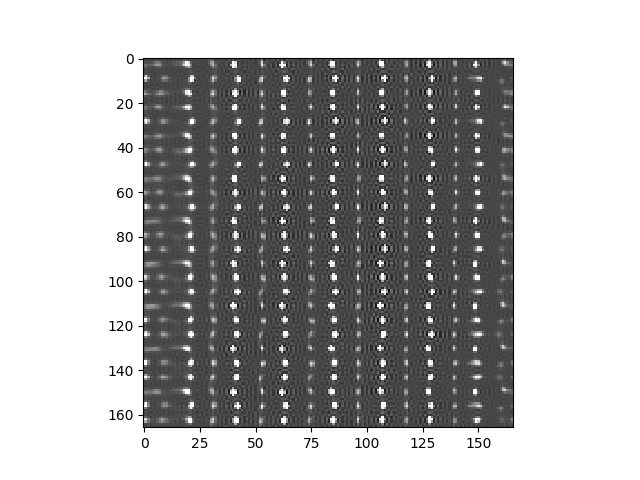

In [ ]:
one_grain_indices = np.argmax(angles)
one_grain = middle_atoms # [one_grain_indices]
print(one_grain.shape)
one_grain_angle = np.max(one_grain[:, 2]%np.radians(90))


gamma = np.radians(layer.cell.angles()[2])
length = 17
plt.close('all')
plt.figure()
plt.imshow(image.T, interpolation='nearest',cmap='gray', vmax=np.median(np.array(image))+3*np.std(np.array(image)))

init = 10
projection_tags = {'lattice_vector': {'a': np.array([np.cos(one_grain_angle)*length, np.sin(one_grain_angle)*length]),
                                      'b': np.array([np.cos(one_grain_angle+gamma)*length, np.sin(one_grain_angle+gamma)*length]) },
                   'allowed_variation': 5,
                   'distance_unit_cell':  length*1.04}
layer.info['projection'] = projection_tags
hop1, ideal = pyTEMlib.graph_tools.breadth_first_search2(blobs[:,:2], init, layer)
init = 200

hop2, ideal = pyTEMlib.graph_tools.breadth_first_search2(blobs[:,:2], init, layer)
plt.scatter(hop1[:,0], hop1[:,1], c='red', alpha = 0.3)
plt.scatter(hop2[:,0], hop2[:,1], c='blue', alpha = 0.3)


one_grain_angle